In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scvelo as scv
import scipy as sc
import seaborn as sns

from scipy import stats
from numpy.random import beta, poisson
from scipy.special import j_roots
from scipy.special import beta as beta_fun
from matplotlib import pyplot as plt

In [2]:
adata = ad.read('../data/processed/mus_musculus_preprocessed_all_params.h5ad')
c57 = adata.to_df('allele_c57').transpose()
cast = adata.to_df('allele_cast').transpose()

In [3]:
def dBP(at, alpha, bet, lam):
    at.shape = (len(at),1)
    np.repeat(at, 50, axis = 1)
    def fun(at, m):
        if(max(m) < 1e6):
            return(stats.poisson.pmf(at,m))
        else:
            return(stats.norm.pdf(at,loc=m,scale=sqrt(m)))
    if alpha <= 0 or bet <= 0:
        return np.nan
    x,w = j_roots(50,alpha = bet-1, beta = alpha - 1)
    gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
    prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
    return(prob)

In [4]:
adata.var.columns

Index(['Accession', 'Chromosome', 'End', 'Start', 'Strand', 'sum_allele_c57',
       'sum_allele_cast', 'sum_ratio_allele_c57', 'sum_ratio_allele_cast',
       'ratio_sum_allele_c57', 'ratio_sum_allele_cast',
       'ratio_mean_allele_c57', 'ratio_mean_allele_cast',
       'ratio_std_allele_c57', 'ratio_std_allele_cast', 'allele_p_value',
       'gene_name', 'chromosome', 'autosomes', 'nuclear', 'Ribosomal_prot',
       'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma',
       'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood',
       'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s',
       'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'c57_kon',
       'c57_koff', 'c57_ksyn', 'cast_kon', 'cast_koff', 'cast_ksyn',
       'total_kon', 'total_koff', 'total_ksyn', 'spliced_kon', 'spliced_koff',
       'spliced_ksyn', 'unspliced_kon', 'unspliced_koff', 'unspliced_ksyn',
       'total_s_u_kon', 'total_s_u_koff', 'total_s_u_k

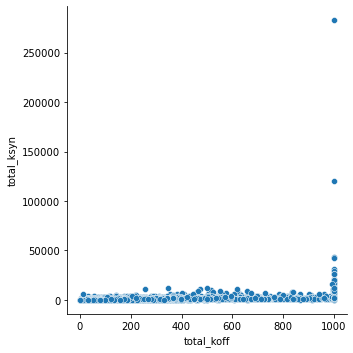

In [9]:
sns.relplot(data=adata.var, x="total_koff", y="total_ksyn")
plt.savefig('../data/figures/sandberg/koff_vs_ksyn/Fig_scatterplot_koff_vs_ksyn_sandberg.pdf')

In [6]:
df = adata.var[(adata.var.total_ksyn > 40000)]
df

,Accession,Chromosome,End,Start,Strand,sum_allele_c57,sum_allele_cast,sum_ratio_allele_c57,sum_ratio_allele_cast,ratio_sum_allele_c57,...,spliced_ksyn,unspliced_kon,unspliced_koff,unspliced_ksyn,total_s_u_kon,total_s_u_koff,total_s_u_ksyn,unspliced_by_total_kon,unspliced_by_total_koff,unspliced_by_total_ksyn
Gene,,,,,,,,,,,,,,,,,,,,,
Cacnb1,ENSMUSG00000020882,11,98023034,98001508,-,9022.0,8853.0,0.504727,0.495273,343.022768,...,1667.724136,0.038673,7.987345,1289.863737,0.061471,13.645979,1667.724136,0.012743,3.950744,4.850247
Ict1,ENSMUSG00000018858,11,115412674,115403752,+,5382.0,6086.0,0.469306,0.530694,320.910005,...,1.000000,0.018234,0.523140,64.683991,3.188106,0.001000,1.000000,0.001000,1.361988,16.439722
0610007P22Rik,ENSMUSG00000015126,17,25242798,25240170,+,3197.0,3168.0,0.502278,0.497722,343.692016,...,2830.297801,0.169317,19.372730,713.844421,1.709931,19.663155,2830.297801,0.001000,1.364187,5.038011
Phb2,ENSMUSG00000004264,6,124716950,124712336,+,2313.0,2949.0,0.439567,0.560433,191.312221,...,129935.294070,0.074890,1.617056,49.488060,3.301603,311.510200,129935.294070,0.001000,1.361826,138.788261


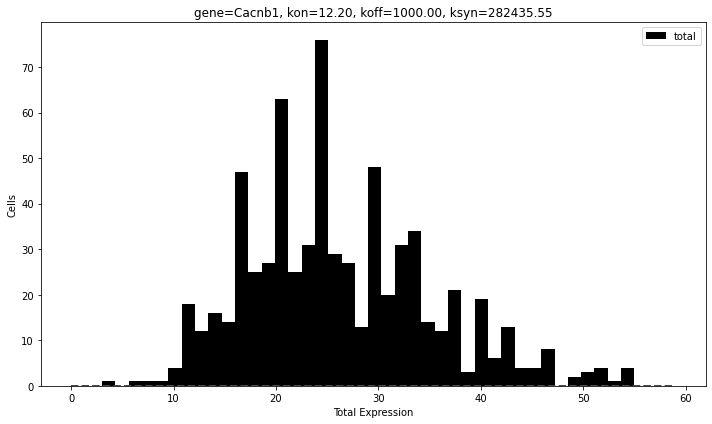

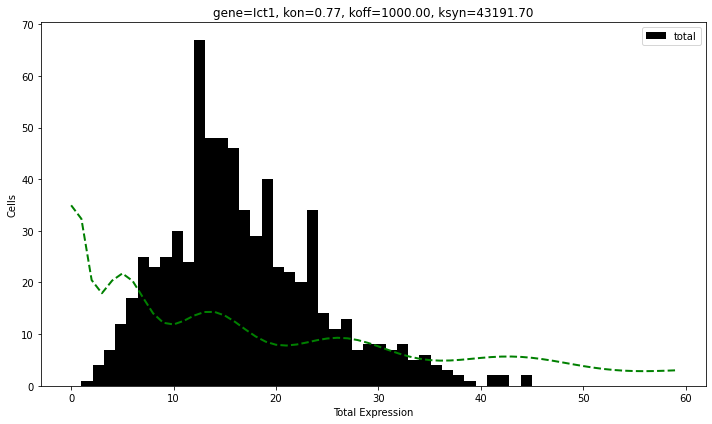

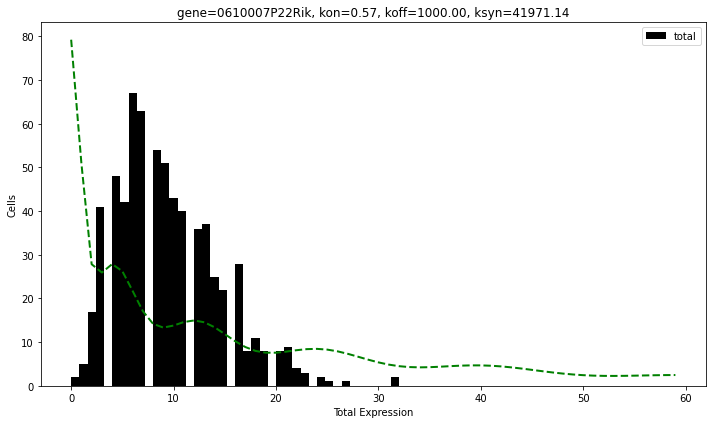

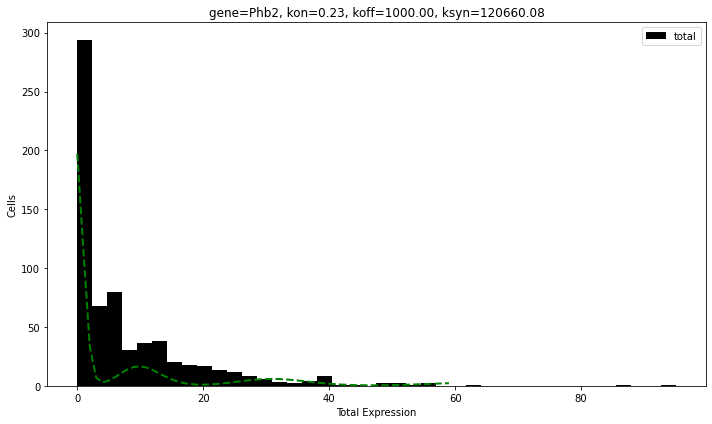

In [7]:
plt.rcParams["figure.figsize"] = (10,6)
for x in df.index:
    cells = 682
    gene = x
    kon = df.loc[x].total_kon
    koff = df.loc[x].total_koff
    ksyn = df.loc[x].total_ksyn
    mat_c57 = c57.loc[x][pd.notnull(c57.loc[x])]
    pat_cast = cast.loc[x][pd.notnull(cast.loc[x])]
    plt.hist(mat_c57+pat_cast, bins=40, label='total', color='black')
    plt.plot(cells*dBP(np.arange(60), kon, koff, ksyn),'g--',linewidth=2)
    plt.xlabel("Total Expression")
    plt.ylabel("Cells")
    plt.title("gene=%s, kon=%.2f, koff=%.2f, ksyn=%.2f" % (gene,kon, koff, ksyn))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('../data/figures/sandberg/koff_vs_ksyn/Fig_binplot_{}_total_sandberg.pdf'.format(gene))
    plt.show()


saving figure to file ../data/figures/sandberg/koff_vs_ksyn/Fig_scatterplot_Cacnb1_total_sandberg.pdf


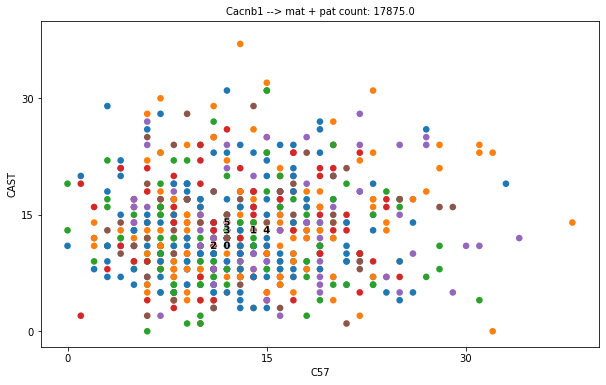

saving figure to file ../data/figures/sandberg/koff_vs_ksyn/Fig_scatterplot_Ict1_total_sandberg.pdf


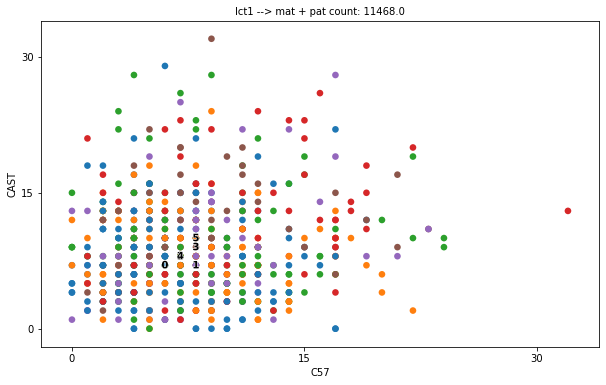

saving figure to file ../data/figures/sandberg/koff_vs_ksyn/Fig_scatterplot_0610007P22Rik_total_sandberg.pdf


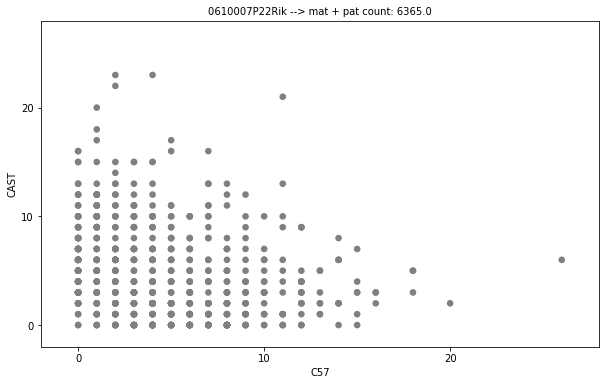

saving figure to file ../data/figures/sandberg/koff_vs_ksyn/Fig_scatterplot_Phb2_total_sandberg.pdf


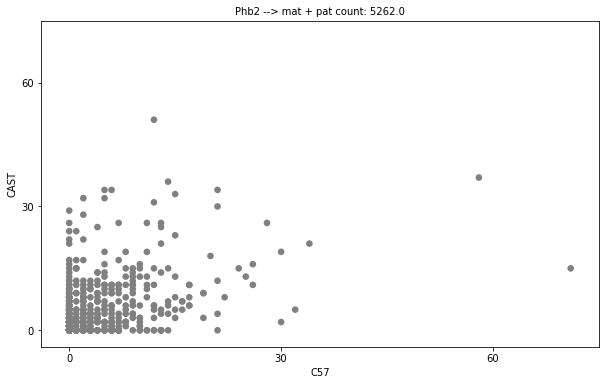

In [8]:
for x in df.index:
    mat_c57 = c57.loc[x][pd.notnull(c57.loc[x])]
    pat_cast = cast.loc[x][pd.notnull(cast.loc[x])]
    
    total_counts = np.sum(mat_c57) + np.sum(pat_cast)
    
    max_c57 = np.max(mat_c57)
    max_cast= np.max(pat_cast)
    max_count = np.max([max_c57, max_cast])
    pad = 1+ int(0.05 * max_count)
    x_lim = (-pad, max_count + pad)
    y_lim = (-pad, max_count + pad)
    
    scv.pl.scatter(adata, x=mat_c57, y=pat_cast, normalize_data= False,
                   xlabel='C57', ylabel='CAST', title=f"{x} --> mat + pat count: {total_counts}",
                   xlim=x_lim, ylim=y_lim, save='../data/figures/sandberg/koff_vs_ksyn/Fig_scatterplot_{}_total_sandberg.pdf'.format(x))
    plt.show()